In [38]:
!pip install GaugeRnR

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\users\a0822\appdata\roaming\python\python311\site-packages\magic_impute-3.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import os
import keras
import datetime
import GaugeRnR
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.tree import DecisionTreeRegressor
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split

<img src="https://sixsigmastudyguide.com/wp-content/uploads/2021/02/p8.png" width="1200" height="400">
<img src="https://sixsigmastudyguide.com/wp-content/uploads/2021/02/u3.png" width="1200" height="400">

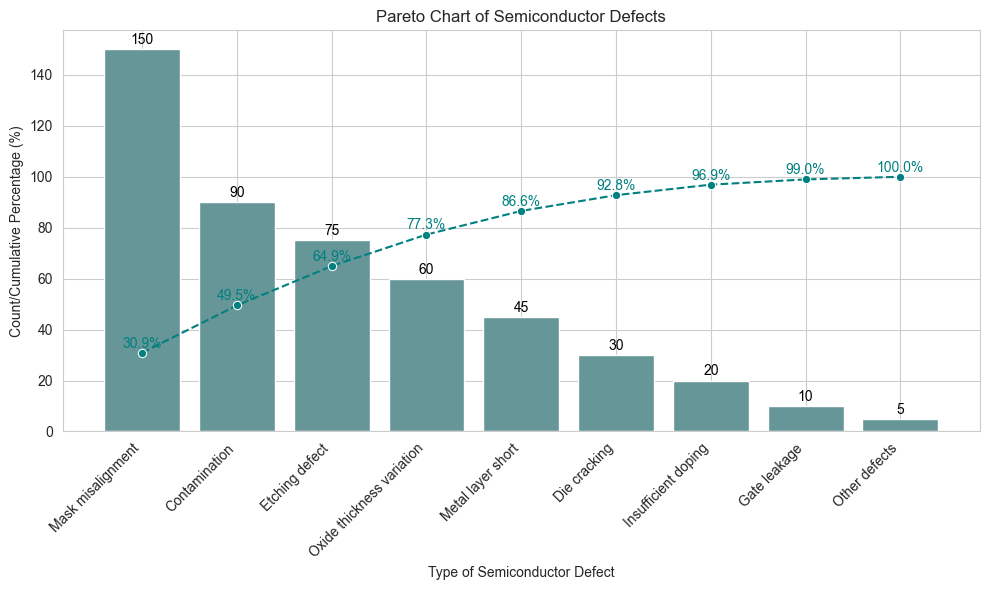

In [40]:
# 柏拉圖 -> 用於突出可識別出「少數關鍵錯誤類型之問題」的影響（即80/20法則），並專注於改進-> 條形圖表示每種錯誤的發生率 / 折線圖表示累積百分比，幫助判斷哪些類型的錯誤對總體影響最大
import warnings

warnings.filterwarnings("ignore")

# 模擬半導體製造過程中的缺陷數據
df = pd.DataFrame({'Defect Type': [20, 75, 90, 150, 60, 30, 45, 10, 5]})
df.index = ['Insufficient doping', 'Etching defect','Contamination', 'Mask misalignment', 'Oxide thickness variation', 
            'Die cracking', 'Metal layer short' , 'Gate leakage', 'Other defects']

# 按缺陷次數降序排序，便於製作柏拉圖
df = df.sort_values(by='Defect Type', ascending=False)

# 計算每種類型缺陷的發生百分比
df['Percent of Defects'] = df['Defect Type'] / df['Defect Type'].sum() * 100

# 計算累積百分比
df['Cumulative Percent'] = df['Percent of Defects'].cumsum()

# 設置圖表背景為網格風格
sns.set_style("whitegrid") 
fig, ax1 = plt.subplots(figsize=(10, 6))
for i, v in enumerate(df['Defect Type']):
    ax1.text(i, v + 2, str(v), color='black', ha='center')
# 條形圖顯示每種類型的缺陷次數
sns.barplot(x=df.index, y='Defect Type', color='cadetblue', data=df)
# 折線圖顯示累積百分比 / 幫助判斷哪些錯誤類型對總體影響最大
sns.lineplot(x=df.index, y='Cumulative Percent', color='teal', data=df, marker='o', linestyle='--')
# # 在折線圖上添加累積百分比的標籤
for i, value in enumerate(df['Cumulative Percent']):
    # x: 表示每個數據點的索引位置
    # y：位置在縱軸上的累積百分比值（加 2 是為了讓數字稍微高於點）
    plt.text(i, value + 2, f"{value:.1f}%", color='teal', ha='center', fontsize=10)
# 圖表標籤和標題
plt.xlabel('Type of Semiconductor Defect')
plt.ylabel('Count/Cumulative Percentage (%)')
plt.title('Pareto Chart of Semiconductor Defects')
# 將橫軸的類型名稱旋轉45度，並右對齊，避免名稱過長時重疊
plt.xticks(rotation=45, ha='right')
plt.grid(True) 
plt.tight_layout()
plt.show()

In [41]:
# 帕累托圖（Pareto Chart）-> 結合條形圖與折線圖的視覺化工具，常用於分析並顯示某些問題或類別的貢獻比例，便於識別最重要的問題或因素
# problems：類別名稱的列表（例如，問題、缺陷類型等）。
# values：每個類別對應的數值列表（例如，問題的發生次數或影響程度）。

# Pareto Chart
def Pareto(problems, values):
    # 創建 DataFrame 並處理數據
    # 創建一個 Pandas DataFrame，將 values 作為列，並將 problems 設為索引。
    df = pd.DataFrame({'Values': values})
    df.index = problems
    # 按照 Values 列的數值大小從高到低進行排序，以便帕累托圖的條形圖從高到低排列。
    df = df.sort_values(by='Values',ascending=False)
    # 計算累積百分比（Cumulative Percentage）：df["Values"].cumsum()：計算數值的累積和。df["Values"].sum()：計算數值總和。
    # 累積百分比用於繪製帕累托圖的折線部分，顯示每個類別及其累積的貢獻比例。
    df["cumpercentage"] = df["Values"].cumsum()/df["Values"].sum()*100
    # 繪製條形圖
    # 設置圖表大小為寬 15 英寸，高 5 英寸。
    plt.figure(figsize=(15,5))
    # 使用 plt.bar 繪製條形圖：df.index：條形圖的 x 軸標籤（類別名稱）。df["Values"]：條形圖的高度（每個類別的值）。color="C0"：條形圖顏色。
    plt.bar(df.index, df["Values"], color="C0")
    # 使用 plt.xticks(rotation=90) 將 x 軸標籤旋轉 90 度，便於顯示長文字標籤。
    plt.xticks(rotation=90)
    # 繪製累積百分比折線圖
    # 使用 plt.twinx() 創建一個共享 x 軸的次坐標軸，用來繪製累積百分比折線圖。
    ax = plt.twinx()
    # 使用 ax.plot 繪製折線圖：df.index：x 軸的類別名稱。df["cumpercentage"]：y 軸的累積百分比。color="C9"：折線圖顏色。marker="."：在折線圖上標記每個數據點。
    ax.plot(df.index, df["cumpercentage"], color="C9", marker=".")
    # 格式化 y 軸與其他設定
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.title("Pareto Diagram")
    plt.tick_params(axis="y", colors="k")
    plt.tick_params(axis="y", colors="k")
    plt.grid()
    plt.show()

In [42]:
problems=['Insufficient doping', 'Etching defect','Contamination', 'Mask misalignment', 'Oxide thickness variation', 
            'Die cracking', 'Metal layer short' , 'Gate leakage', 'Other defects']
values=[20, 75, 90, 150, 60, 30, 45, 10, 5]

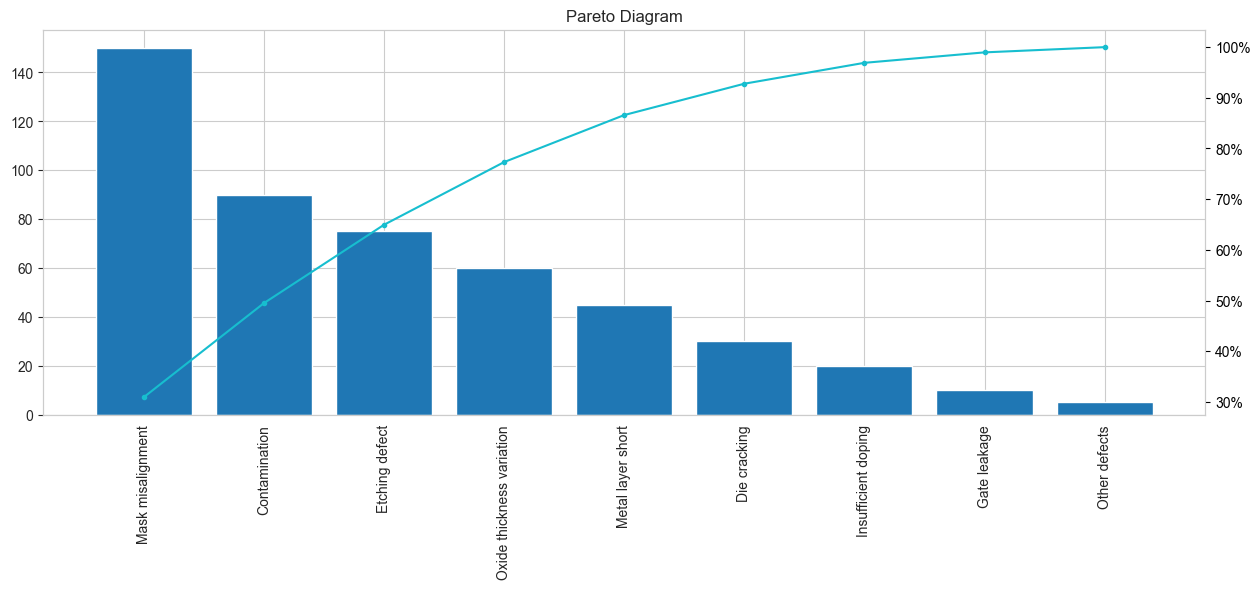

In [43]:
Pareto(problems,values)

In [44]:
# 個別移動範圍控制圖 (Individual Moving Range Control Chart) -> (IMR Chart;X-MR)
# 用於監控個別觀測值（X）的穩定性以及它們之間變化的幅度（mR, Moving Range）
# 移動極差圖表則監控定期收集資料點時的流程變化。換句話說，移動極差圖追蹤每個測量值與其前一個測量值之間的絕對差。
# 單一圖表顯示單一資料點並監控過程中的變化，而 X̅ 則監控隨時間的變化。
# 對於 I-MR 圖表，n 始終等於 2（因為我們正在計算兩個連續點的移動平均值，換句話說，它基本上是將當前狀態與先前的狀態進行比較）。

# 應用場景:
# 1.監控個別觀測值的穩定性，常用於監控單個製造過程參數（例如：機器溫度、壓力）。
# 2.檢查觀測值之間的變化幅度(mR)是否在可接受範圍內。
# 優勢:
# 1.不需要分組數據，適合處理連續的單個觀測值。
# 2.同時分析觀測值 (X) 和變化幅度 (mR)，更全面地檢測過程穩定性。


class MR:
    # data: 一個 1D 的數據陣列，表示單次測量的觀測值。
    def fit(self,data):
        # 原始觀測數據
        self.X = data
        # 觀測值feature的總數
        self.number_of_sample = len(self.X)
        self.mR = np.zeros(((self.number_of_sample-1),1))
        for i in range(len(self.mR)):
            # 每個觀測值之間的移動範圍（絕對差）。 -> 計算出每個相鄰觀測值之間的移動範圍，並存儲在 self.mR 中
            self.mR[i] = abs(self.X[i+1] - self.X[i])
    # d2: 由樣本大小決定的係數，用於計算 X 的控制界限。D4, D3: 用於計算 mR 控制界限的係數。
    def ControlChart(self,d2,D4,D3):
        # 個別中心線、控制下限和控制上限
        ucl_X   = self.X.mean() + (3*self.mR.mean()/d2)
        cl_X    = self.X.mean() 
        lcl_X   = self.X.mean() - (3*self.mR.mean()/d2)
        # 移動全距的中心線、控制下限、控制上限
        ucl_mR   = D4*self.mR.mean()
        cl_mR    = self.mR.mean() 
        lcl_mR   = D3*self.mR.mean()

        # 圖1
        # 繪製每個觀測值（X），並顯示 UCL、CL、LCL 的水平線。 -> 個別中心線、控制下限和控制上限
        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker=".",color="k",label="X")
        # 特別標示超過 UCL 和低於 LCL 的點
        for i, x in enumerate(self.X):
            if x > ucl_X:  # 超過 UCL
                plt.scatter(i, x, color="red", label="Above UCL" if i == 0 else "")
            elif x < lcl_X:  # 低於 LCL
                plt.scatter(i, x, color="blue", label="Below LCL" if i == 0 else "")
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={}".format(ucl_X.round(2)))
        plt.plot([cl_X]*len(self.X),color="c",label="CL={}".format(cl_X.round(2)))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={}".format(lcl_X.round(2)))
        plt.title("I Chart")
        plt.xticks(np.arange(len(self.X)))
        plt.legend()
        plt.show()
        
        # 圖2
        # 繪製每個移動範圍（mR），並顯示 UCL、CL、LCL 的水平線。 -> 移動全距的中心線、控制下限、控制上限
        plt.figure(figsize=(15,5))
        plt.plot(self.mR ,marker=".",color="k",label="MR")
        # 特別標示超過 UCL 和低於 LCL 的點
        for i, mr in enumerate(self.mR):
            if mr > ucl_mR:  # 超過 UCL
                plt.scatter(i, mr, color="red", label="Above UCL" if i == 0 else "")
            elif mr < lcl_mR:  # 低於 LCL
                plt.scatter(i, mr, color="blue", label="Below LCL" if i == 0 else "")
        plt.plot([ucl_mR ]*len(self.X),color="r",label="UCL={}".format(ucl_mR.round(2)))
        plt.plot([cl_mR ]*len(self.X),color="c",label="CL={}".format(cl_mR.round(2)))
        plt.plot([lcl_mR ]*len(self.X),color="r",label="LCL={}".format(lcl_mR.round(2)))
        plt.title("MR Control Chart")
        plt.xticks(np.arange(len(self.mR)))
        plt.legend()
        plt.show()

        # 圖3
        # 分別繪製 X 和 mR 的箱型圖，用於觀察它們的分佈。
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.boxplot(x=self.X)
        plt.title("Boxplot of X")
        plt.xlabel("X")
        plt.subplot(1,2,2)
        plt.boxplot(x=self.mR )
        plt.title("Boxplot of MR")
        plt.xlabel("MR")
        plt.show()

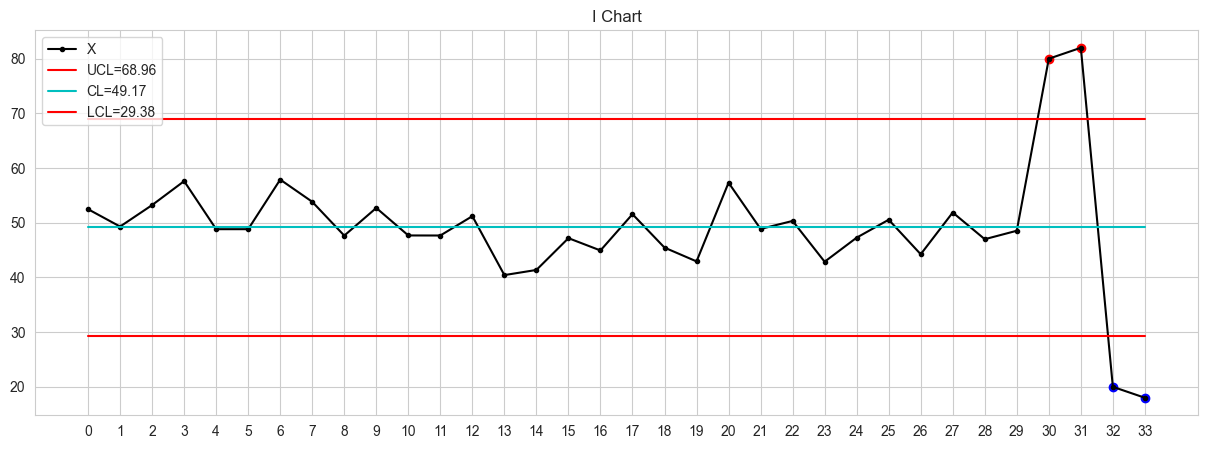

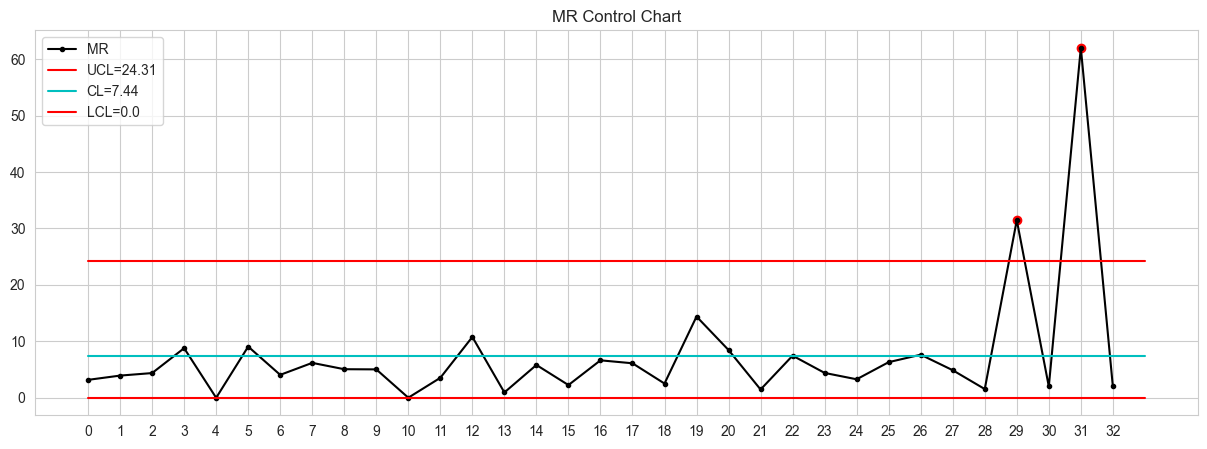

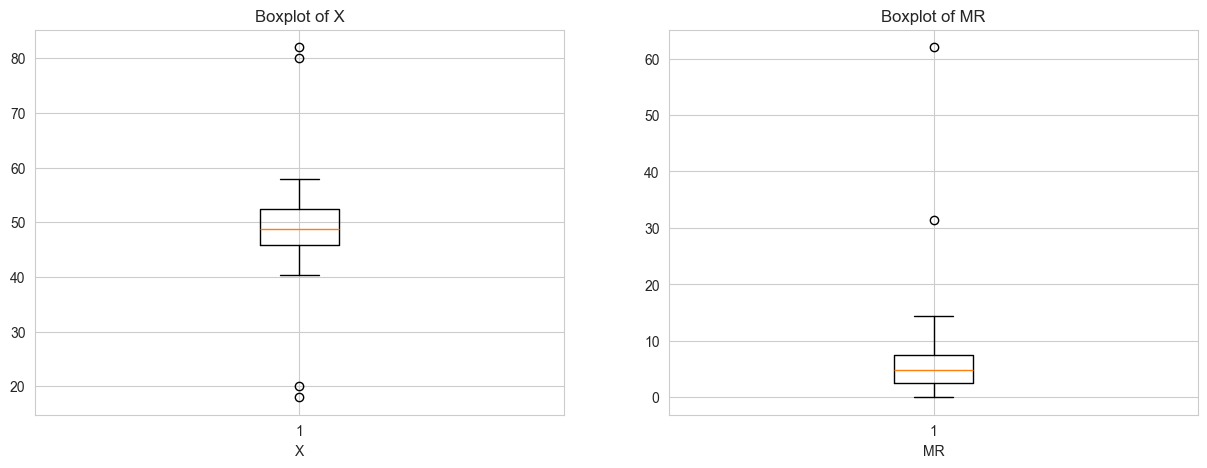

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# 生成假資料
np.random.seed(42)  # 固定隨機種子
normal_data = np.random.normal(loc=50, scale=5, size=30)  # 正常數據 (平均50, 標準差5)

# 插入超過 UCL 和低於 LCL 的異常點
outliers = [80, 82, 20, 18]  # 兩個超過 UCL，兩個低於 LCL

# 合併數據
data_with_outliers = np.concatenate([normal_data, outliers])

# 創建 MR 控制圖類別
mr_chart = MR()
mr_chart.fit(data_with_outliers)

# 設定控制界限係數
d2 = 1.128  # 樣本大小為2的 d2 值
D4 = 3.267  # 樣本大小為2的 D4 值
D3 = 0      # 樣本大小為2的 D3 值

# 繪製控制圖
mr_chart.ControlChart(d2, D4, D3)

In [46]:
# X(bar) (平均值) - R (全距) 控制圖表 (Control Charts)
# 應用場景:監控製造過程的穩定性。檢測過程是否超出控制界限。發現過程中的變異和潛在問題。

class XR:
    # 該方法接受一個 data 作為輸入，計算控制圖中所需的樣本特徵
    # data 是一個 2D 的數據陣列，每row代表一個樣本，每column代表該樣本中的觀測值。
    # 通過 fit 函式計算每個樣本的均值與極差
    def fit(self,data):
        # self.sample_size：每個樣本的大小（觀測值feature的數量）。
        self.sample_size = len(data[0])
        # 樣本數量
        self.number_of_sample = len(data)
        self.X = np.zeros((self.number_of_sample,1))
        self.R = np.zeros((self.number_of_sample,1))
        # 遍歷所有樣本
        for i in range(self.number_of_sample):
            # 每個樣本的均值
            self.X[i] = data[i].mean()
            # 每個樣本的全距（最大值 - 最小值）
            self.R[i] = data[i].max() - data[i].min()
        # 保存原始數據
        self.data = data
        
    # 控制圖生成
    # 該方法生成 X 和 R 控制圖，以及對應的上下控制界限 (UCL, LCL) 和中心線 (CL)。同時，它還會生成數據的箱型圖。
    # A2, D3, D4：這些是控制圖的係數，基於樣本大小來確定，用於計算控制界限。
    def ControlChart(self,A2,D3,D4):
        ucl_X   = self.X.mean() + A2*self.R.mean()
        cl_X    = self.X.mean() 
        lcl_X   = self.X.mean() - A2*self.R.mean()
        ucl_R   = D4*self.R.mean()
        cl_R    = self.R.mean() 
        lcl_R   = D3*self.R.mean()
        
        # 圖1
        # 箱型圖 (Boxplot) -> 顯示數據的分佈情況
        plt.figure(figsize=(15,5))
        plt.title("Boxplot for {} Observations\nSample Size {}".format(len(self.data),len(self.data[0])))
        plt.boxplot(self.data.T)
        plt.show()

        # 圖2
        plt.figure(figsize=(15,5))
        # 使用 plt.plot 繪製每個樣本的均值
        plt.plot(self.X,marker="o",color="k",label="X")
        # 顯示 UCL、CL、LCL 的水平線，並用不同顏色標識
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={}".format(ucl_X.round(2)))
        plt.plot([cl_X]*len(self.X),color="c",label="CL={}".format(cl_X.round(2)))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={}".format(lcl_X.round(2)))
        plt.title("X Chart")
        plt.xticks(np.arange(len(self.data)))
        plt.legend()
        plt.show()
        
        # 圖3
        plt.figure(figsize=(15,5))
        # 顯示每個樣本的極差，並繪製 UCL、CL、LCL 水平線
        plt.plot(self.R,marker="o",color="k",label="R")
        plt.plot([ucl_R]*len(self.X),color="r",label="UCL={}".format(ucl_R.round(2)))
        plt.plot([cl_R]*len(self.X),color="c",label="CL={}".format(cl_R.round(2)))
        plt.plot([lcl_R]*len(self.X),color="r",label="LCL={}".format(lcl_R.round(2)))
        plt.title("R Control Chart")
        plt.xticks(np.arange(len(self.data)))
        plt.legend()
        plt.show()
        
        # 圖4
        # 在最後一個圖中分別展示均值 X 和全距 R 的分佈
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.boxplot(x=self.X)
        plt.title("Boxplot Of X")
        plt.xlabel("X")
        plt.subplot(1,2,2)
        plt.boxplot(x=self.R)
        plt.title("Boxplot Of R")
        plt.xlabel("R")
        plt.show()

In [47]:
data = np.array([[57, 46, 62, 23, 19],
       [52, 49, 42, 60, 32],
       [64, 53, 33, 20, 32],
       [46, 61, 55, 24, 44],
       [26, 47, 21, 62, 48],
       [36, 64, 63, 42, 38],
       [22, 52, 44, 49, 43],
       [56, 38, 56, 44, 46],
       [52, 33, 40, 30, 65],
       [57, 55, 30, 35, 46],
       [53, 24, 63, 49, 43],
       [24, 33, 38, 67, 24],
       [65, 36, 32, 48, 35],
       [38, 61, 48, 43, 38],
       [68, 42, 21, 29, 43],
       [60, 48, 44, 19, 60],
       [43, 28, 32, 65, 22],
       [57, 47, 69, 56, 24],
       [31, 29, 48, 63, 42],
       [39, 68, 20, 51, 26]])

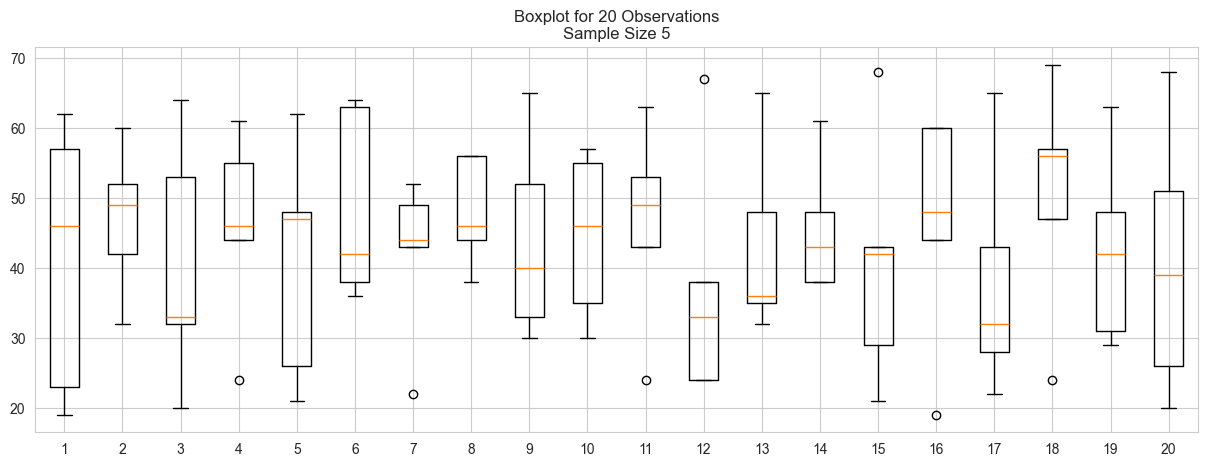

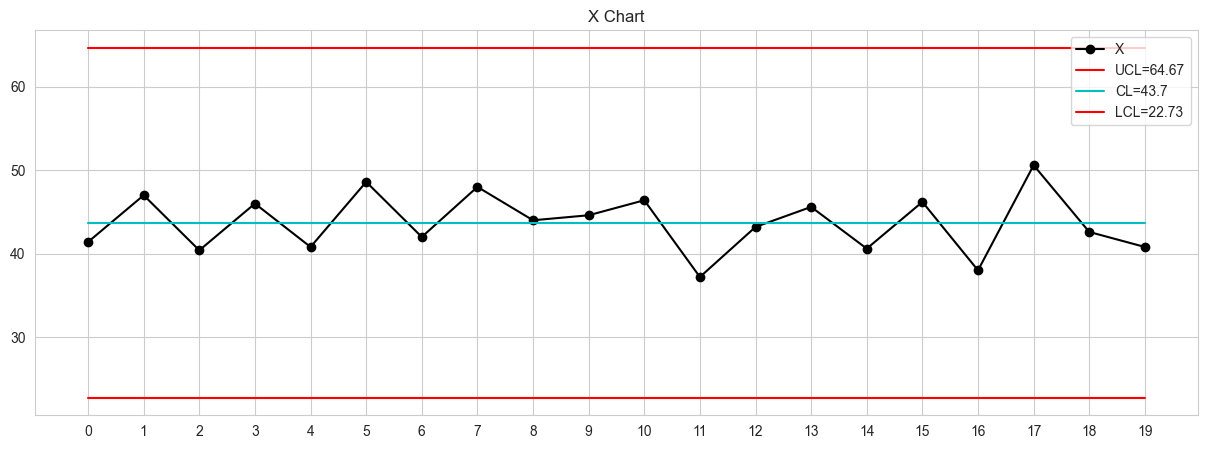

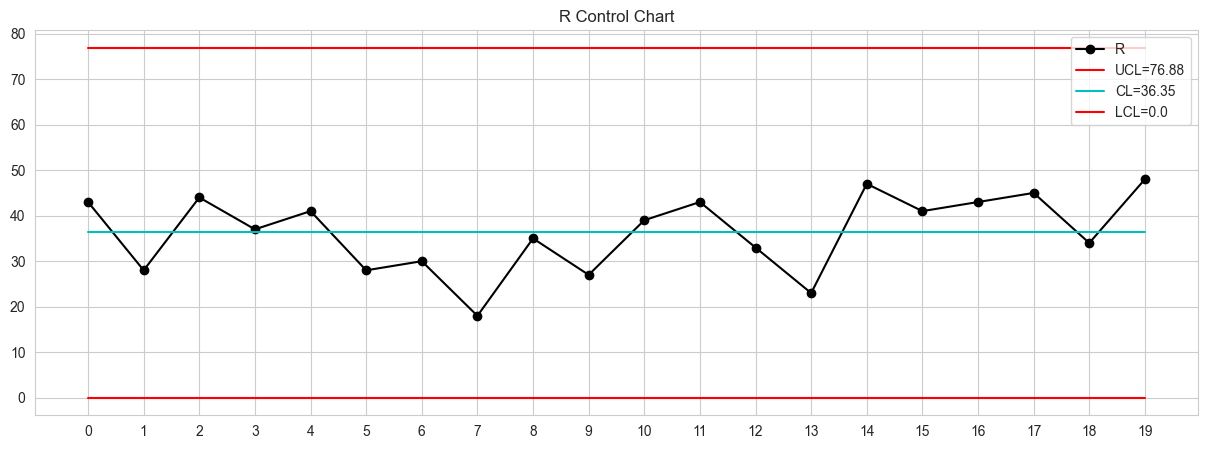

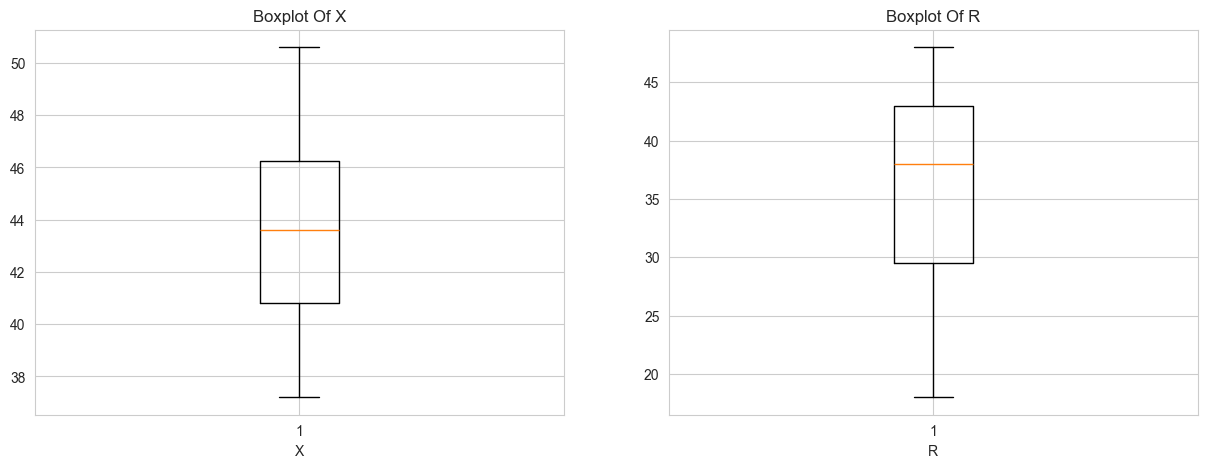

In [48]:
chart = XR()
chart.fit(data)
chart.ControlChart(A2 = 0.577,D3 = 0 ,D4 = 2.115)

In [49]:
# X(bar) (樣本均值) - S (標準差) 控制圖表 (Control Charts)
# 應用場景: 監控製造過程的穩定性。 分析製造過程的均值和變異性。 偵測製造過程中異常或不穩定的樣本。
# 優勢: 同時分析均值 (X) 和變異性 (S)，更全面地檢測製造過程的穩定性。 簡單直觀的控制圖和箱型圖，方便解讀數據分佈和異常情況。

class XS:
    # data：一個 2D 的數據陣列，其中每row代表一個樣本，每column代表該樣本中的觀測值feature
    def fit(self,data):
        # 每個樣本中的觀測值數量
        self.sample_size = len(data[0])
        # 樣本的總數
        self.number_of_sample = len(data)
        self.X = np.zeros((self.number_of_sample,1))
        self.S = np.zeros((self.number_of_sample,1))
        for i in range(self.number_of_sample):
            # 每個樣本的均值
            self.X[i] = data[i].mean()
            # 每個樣本的標準差
            self.S[i] = data[i].std()
        # 原始輸入數據
        self.data = data
    # A3, B3, B4: 這些是 X 和 S 控制圖的係數，基於樣本大小(n)進行選擇，通常來自 SPC 表格
    def ControlChart(self,A3,B3,B4):
        ucl_X   = self.X.mean() + A3*self.S.mean()
        cl_X    = self.X.mean() 
        lcl_X   = self.X.mean() - A3*self.S.mean()
        ucl_S   = B4*self.S.mean()
        cl_S    = self.S.mean() 
        lcl_S   = B3*self.S.mean()

        # 圖1
        # 繪製數據分佈的箱型圖，顯示各樣本觀測值的分佈
        plt.figure(figsize=(15,5))
        plt.title("Boxplot for {} Observations\nSample Size {}".format(len(self.data),len(self.data[0])))
        plt.boxplot(self.data.T)
        plt.show()

        # 圖2
        # 繪製每個樣本的均值，並顯示 UCL、CL、LCL 的水平線。
        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker=".",color="k",label="X")
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={}".format(ucl_X.round(2)))
        plt.plot([cl_X]*len(self.X),color="c",label="CL={}".format(cl_X.round(2)))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={}".format(lcl_X.round(2)))
        plt.title("X Chart")
        plt.xticks(np.arange(len(self.data)))
        plt.legend()
        plt.show()
        
        # 圖3
        # 繪製每個樣本的標準差，並顯示 UCL、CL、LCL 的水平線。
        plt.figure(figsize=(15,5))
        plt.plot(self.S,marker=".",color="k",label="S")
        plt.plot([ucl_S]*len(self.X),color="r",label="UCL={}".format(ucl_S.round(2)))
        plt.plot([cl_S]*len(self.X),color="c",label="CL={}".format(cl_S.round(2)))
        plt.plot([lcl_S]*len(self.X),color="r",label="LCL={}".format(lcl_S.round(2)))
        plt.title("S Control Chart")
        plt.xticks(np.arange(len(self.data)))
        plt.legend()
        plt.show() 
        
        # 圖4
        # 繪製樣本均值和標準差的箱型圖，用於觀察它們的分佈情況。
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.boxplot(x=self.X)
        plt.title("Boxplot of X")
        plt.xlabel("X")
        plt.subplot(1,2,2)
        plt.boxplot(x=self.S)
        plt.title("Boxplot of S")
        plt.xlabel("S")
        plt.show()

Generated Semiconductor Data (First 5 Batches):
[[100.99342831  99.7234714  101.29537708 103.04605971  99.53169325
   99.53172609 103.15842563 101.53486946  99.06105123 101.08512009]
 [ 99.07316461  99.06854049 100.48392454  96.17343951  96.55016433
   98.87542494  97.97433776 100.62849467  98.18395185  97.1753926 ]
 [102.93129754  99.5484474  100.13505641  97.15050363  98.91123455
  100.22184518  97.69801285 100.75139604  98.79872262  99.4166125 ]
 [ 98.79658678 103.70455637  99.97300555  97.88457814 101.64508982
   97.5583127  100.41772719  96.08065975  97.3436279  100.39372247]
 [101.47693316 100.34273656  99.76870344  99.39779261  97.04295602
   98.56031158  99.07872246 102.11424445 100.68723658  96.47391969]]


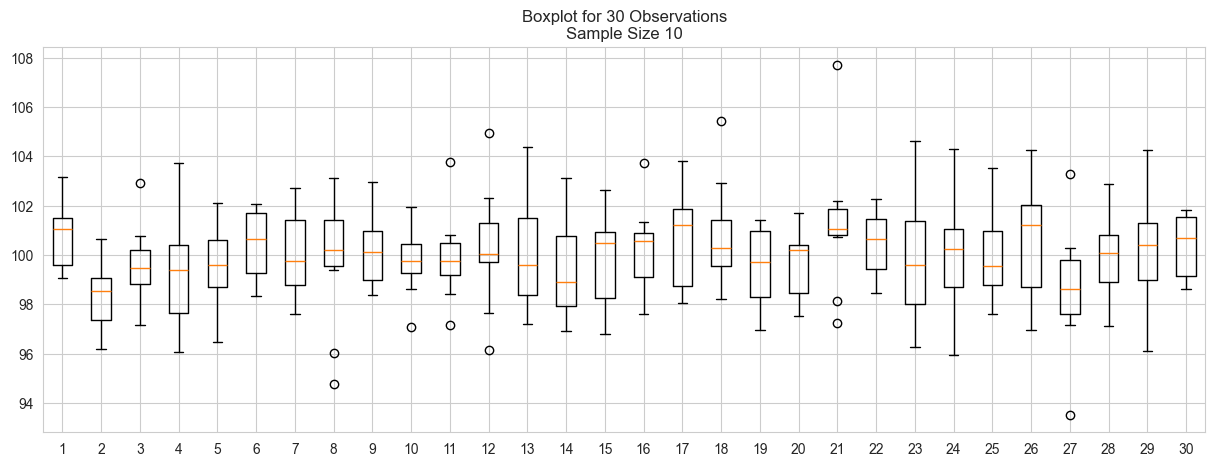

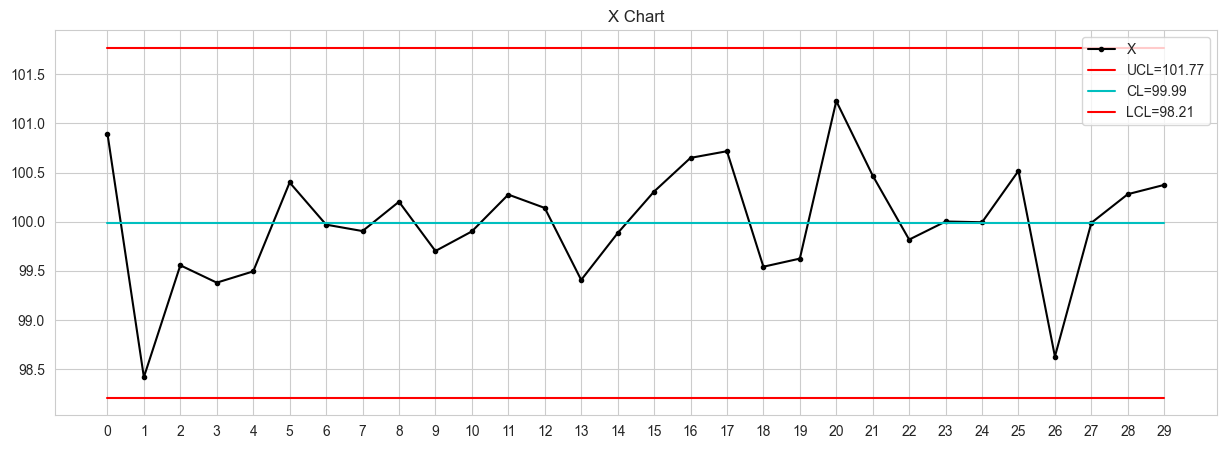

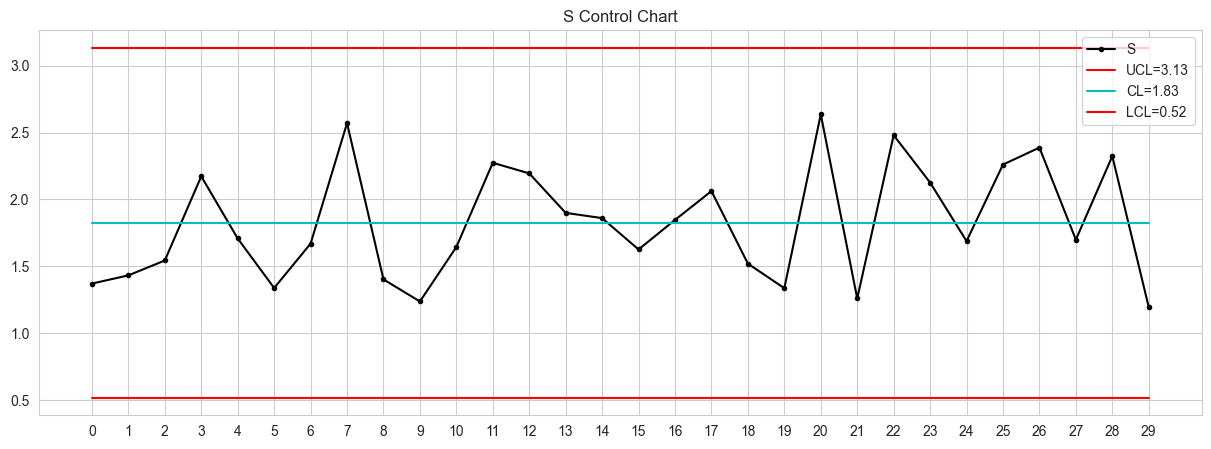

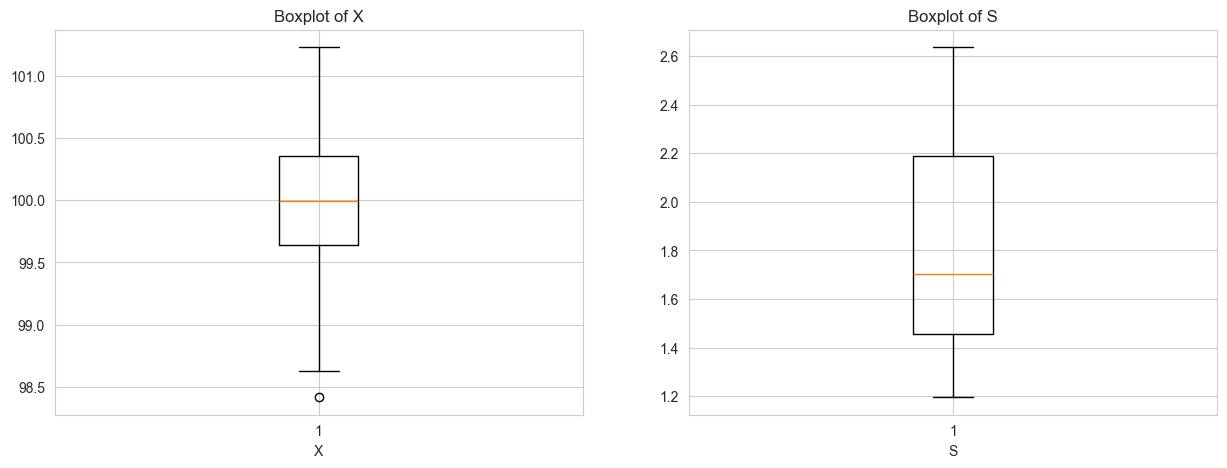

In [50]:
# 模擬半導體製造數據
# 假設每批次樣本大小為10（10個器件），共生成30批次樣本
np.random.seed(42)  # 固定隨機種子以重現結果
# num_samples=30: 總共生成30批次的數據，每批次包含10個樣本觀測值
num_samples = 30  # 批次數
sample_size = 10  # 每批次樣本大小

# 模擬均值穩定在100，標準差在2左右的正態分布數據
# loc=100: 模擬過程的目標均值設定為100（例如某一關鍵尺寸的設計值）
# scale=2: 模擬過程的標準差設定為2，代表正常製造過程中的變異性
data = np.random.normal(loc=100, scale=2, size=(num_samples, sample_size))

# 顯示部分數據
print("Generated Semiconductor Data (First 5 Batches):")
print(data[:5])

# 初始化 XS 類並進行數據擬合
xs_chart = XS()
xs_chart.fit(data)

# 根據 SPC 表查表，設置 A3, B3, B4 的值
# 假設樣本大小為10時：
A3 = 0.975
B3 = 0.284
B4 = 1.716

# 繪製 X 和 S 控制圖
xs_chart.ControlChart(A3, B3, B4)

In [51]:
# P 控制圖 (Proportion Control Chart) -> 用於監控樣本中不良品率或失敗率的穩定性
# 輸出：1.控制圖顯示每個樣本的不良品比例及其是否在控制界限內。 2.直方圖和箱型圖輔助分析數據分佈的形狀和離群值。

class p:
    # 初始化並計算每個樣本的不良品率
    def fit(self,D,n):
        # D：一個包含每個樣本中不良品數量的清單或陣列。
        self.D = D
        # n：每個樣本的總數量 (樣本大小)，假設所有樣本大小一致。
        self.n = n 
        self.p = np.zeros(len(self.D)) 
        # 將樣本數據逐項計算比例值，並儲存到類別變數 self.p
        # 不良品數量 除以 樣本總數量
        for i in range(len(D)):
            self.p[i] = D[i] / n
    def ControlChart(self):
        m      = len(self.p)
        p_mean = self.p.sum() / m
        ucl = p_mean + 3*np.sqrt((p_mean*(1-p_mean))/(self.n))
        cl  = p_mean
        lcl = p_mean - 3*np.sqrt((p_mean*(1-p_mean))/(self.n))
        plt.figure(figsize=(15,5))
        # 繪製樣本的比例值 p
        plt.plot(self.p,marker=".",color="k",label="$p_i$")
        # 標註超出 UCL 和低於 LCL 的點
        for i, value in enumerate(self.p):
            if value > ucl:
                plt.scatter(i, value, color='red', label="Above UCL" if i == 0 else "", zorder=5)
                plt.text(i, value + 0.01, f"{value:.2f}", color="red", ha="center", fontsize=9)
            elif value < lcl:
                plt.scatter(i, value, color='blue', label="Below LCL" if i == 0 else "", zorder=5)
                plt.text(i, value - 0.01, f"{value:.2f}", color="blue", ha="center", fontsize=9)
        # 顯示控制界限（UCL 和 LCL）和中心線（CL）
        plt.plot([ucl]*(len(self.D)),label="UCL={}".format(ucl.round(2)),color="r")
        plt.plot([cl]*(len(self.D)),label="CL={}".format(cl.round(2)),color="c",alpha=0.4)
        plt.plot([lcl]*(len(self.D)),label="LCL={}".format(lcl.round(2)),color="r")
        plt.legend(loc="best")
        plt.xticks(np.arange(len(self.D)))
        plt.title("P Control Chart")
        plt.show()       
        plt.figure(figsize=(15,5))
        # 箱型圖
        plt.subplot(1,2,1)
        plt.boxplot(self.D,vert=False)
        plt.title("Boxplot of Defective Counts")
        plt.ylabel("Defective Counts")
        # 直方圖
        plt.subplot(1,2,2)
        # self.D 是不良品數量的清單 / bins 控制直方圖中的區間數量（bin數）
        # 設定為 int(len(self.D)/3)，意即區間數量等於數據長度的三分之一。 例如，如果 len(self.D) = 12，則 bins = 4，數據將被分為4個區間。 
        # density=True: 表示直方圖的縱軸顯示的是密度而非頻率。確保直方圖的面積總和為 1。 如果設置為 False，縱軸將顯示每個區間內的實際數據點數量。
        plt.hist(self.D,bins=int(len(self.D)/3),density=True,color="#52b69a")
        plt.ylabel("Frequency")
        plt.title("Histogram of Defective Counts")
        plt.show()

In [52]:
data6 =  np.array([12,15,8,10,4,7,16,9,14,10,5,6,17,12,22,8,10,5,13,11,20,18,24,15,9,12,7,13,9,6])

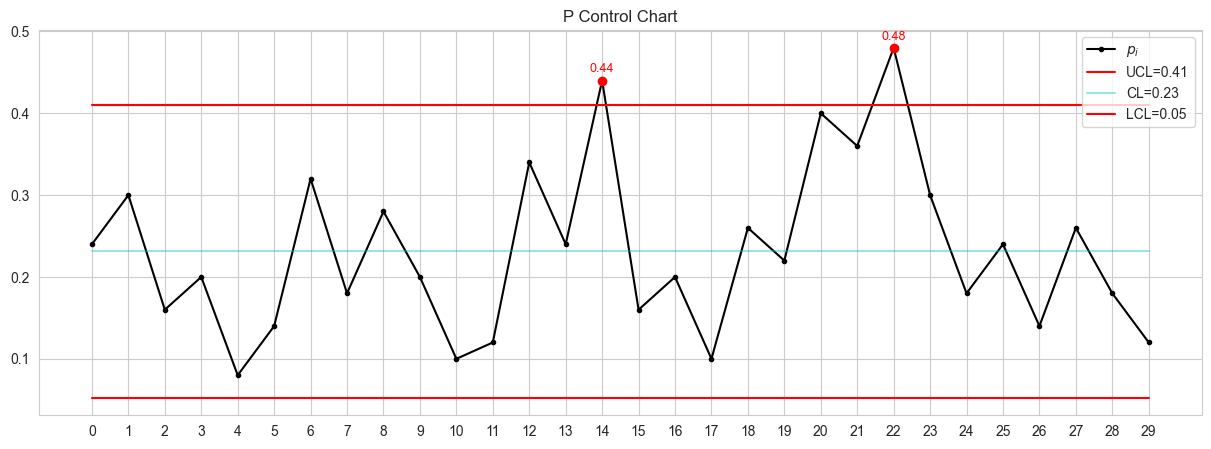

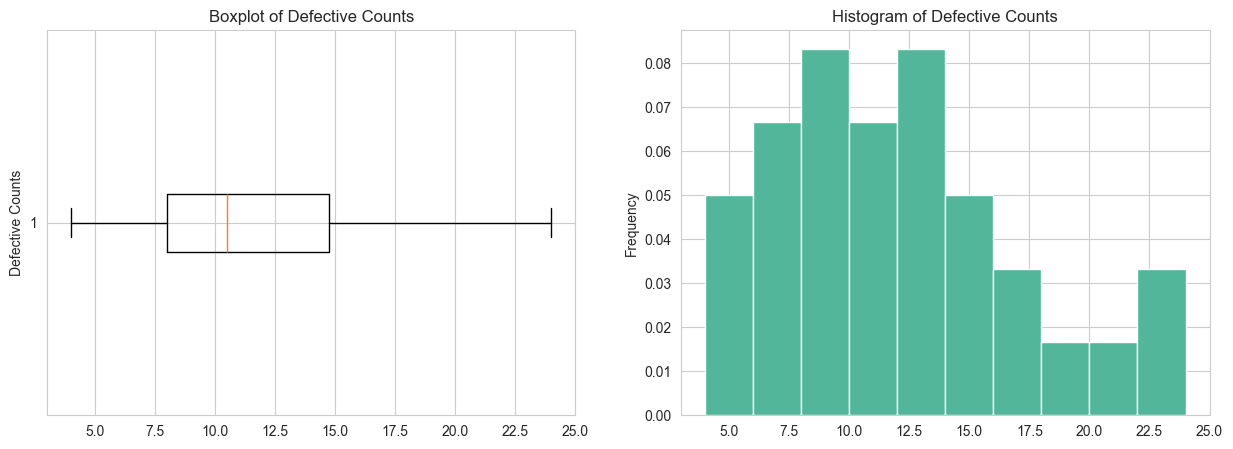

In [53]:
chart = p()
chart.fit(D=data6,n=50)
chart.ControlChart()

In [54]:
# 監控每單位樣本中的不良品數量或缺陷數量的穩定性  ->  可視化樣本的不良品數或缺陷數的變化

class u:
    def fit(self,c,n):
        # c：一個清單或陣列，表示每個樣本中的缺陷總數或不良品總數。
        self.c      = c
        # n：一個清單或陣列，表示每個樣本的檢測單位數量。
        self.n      = n
        # 計算整體的不良品率平均值，儲存於 self.u_mean 中
        self.u_mean = sum(self.c) / sum(self.n)
        # 計算每單位的不良品率，儲存於 self.value 中
        self.value  = np.array(c) /  np.array(n)
    # 支持變標準差倍數： 提供參數以調整控制界限中的標準差倍數
    def ControlChart(self, sigma):
        ucl = self.u_mean + sigma * np.sqrt(self.u_mean/np.mean(self.n))
        cl  = self.u_mean
        lcl = self.u_mean - sigma * np.sqrt(self.u_mean/np.mean(self.n))     
        plt.figure(figsize=(15,5))
        plt.plot(self.value,marker=".",color="k",label="$C_i$")
        # 增加異常點標記
        out_of_control = (self.value > ucl) | (self.value < lcl)
        plt.scatter(np.where(out_of_control), self.value[out_of_control], color='r', label='Out of Control')
        plt.plot([ucl]*len(self.n),color="r",label="UCL={}".format(ucl.round(2)))
        plt.plot([cl]*len(self.n),color="c",alpha=0.4,label="CL={}".format(cl.round(2)))
        plt.plot([lcl]*len(self.n),color="r",label="LCL={}".format(lcl.round(2)))
        plt.xticks(np.arange(len(self.c)))
        plt.legend(loc="best")
        plt.title("u - Control Chart")
        plt.show()
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.boxplot(self.c,vert=False)
        plt.title("Boxplot of Data")
        plt.ylabel("Data")
        plt.subplot(1,2,2)
        plt.hist(self.c,bins=int(len(self.c)/3),density=True,color="#52b69a")
        plt.ylabel("Frequency")
        plt.title("Histogram of Data")
        plt.show()   

Number of Samples: 30
Units per Sample (n): [101 142  64 121 110  70 132 136 124 124 137 149  73  52  71 102  51 137
  79  87  51 113 109  70  82 125 107  71 138  98]
Defects per Sample (c): [ 4  8  3  6  5  6 10  3  2 10  9  8  6  2  4  5  2  6  2  4  4  7  8  4
  5  8  8 10  8  5]


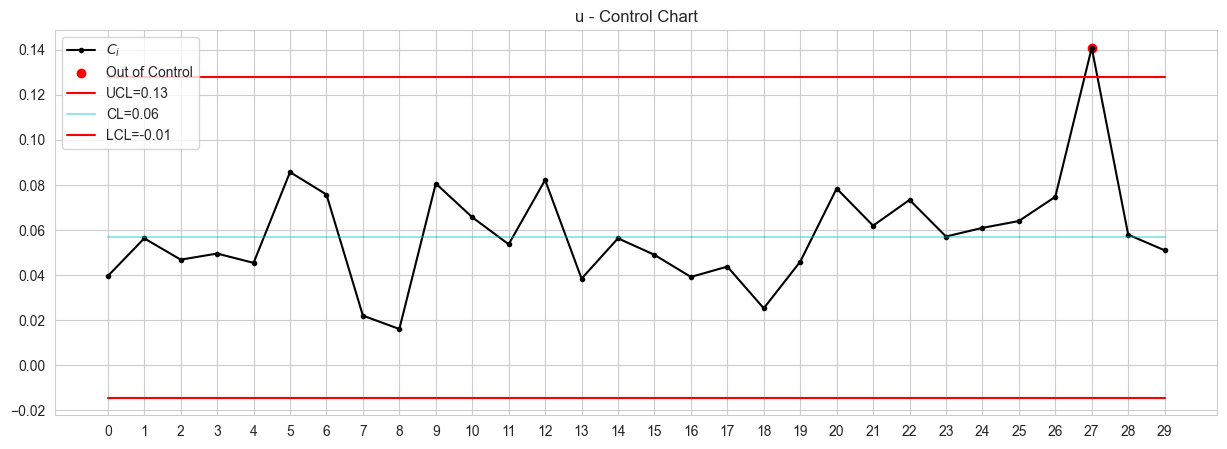

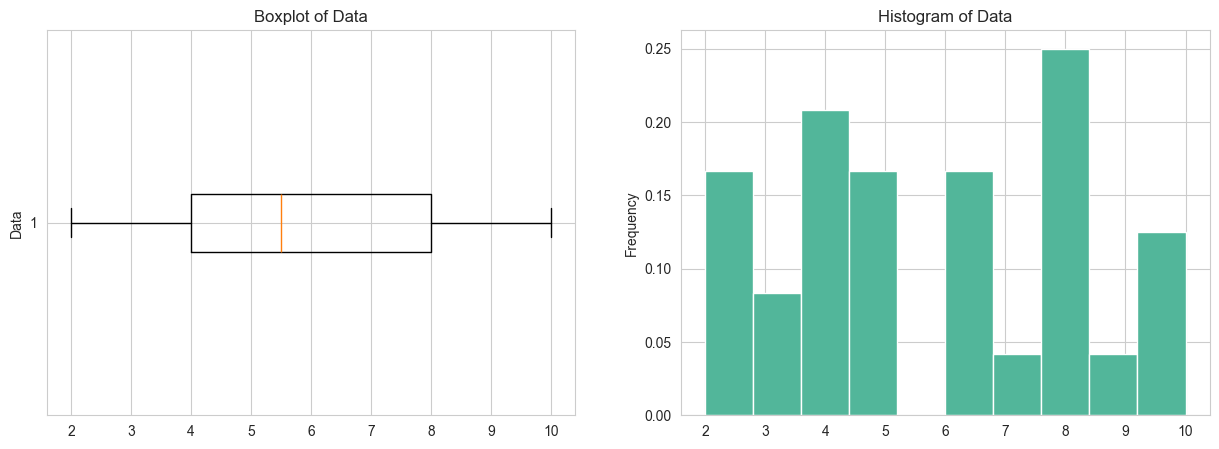

In [55]:
import numpy as np

# 模擬數據
np.random.seed(42)  # 固定隨機種子以保證結果可重現

# 模擬樣本數
num_samples = 30

# 每個樣本的檢測單位數量（假設各樣本的檢測單位數量不同）
n = np.random.randint(50, 150, size=num_samples)  # 每批次單位數量在 50 到 150 之間

# 缺陷數量（假設每個樣本的缺陷數量基於泊松分布）
mean_defect_rate = 0.05  # 假設平均缺陷率
c = np.random.poisson(mean_defect_rate * n)  # 生成缺陷數量

# 顯示生成的數據
print("Number of Samples:", num_samples)
print("Units per Sample (n):", n)
print("Defects per Sample (c):", c)

# 初始化並擬合數據
u_chart = u()
u_chart.fit(c, n)

# 繪製 u 控制圖
u_chart.ControlChart(3)

In [56]:
# EWMA控制圖 (Exponentially Weighted Moving Average Control Chart) -> （指數加權移動平均）
class EWMA:
    # lamda：平滑因子（權重） -> [0,1] -> lamda 越大：越重視最近的數據, lamda 越小：越重視歷史數據
    # mean：數據的目標平均值（理論上應該是穩定製程的期望值）
    def fit(self,data,lamda,mean):
        # X：第 i 個觀測數據
        self.X     = data
        self.z     = np.zeros(len(data))
        self.lamda = lamda
        self.mean  = mean
        # self.z[0] = mean，設定第一個EWMA值等於目標平均值
        self.z[0]  = self.mean
        # z(i)：每個數據點都會加權更新上一個EWMA值 -> 為EWMA值
        for i in range(1,len(self.z)):
            # self.z 儲存了計算出的EWMA序列，用於後續的控制圖繪製
            self.z[i] = self.lamda*self.X[i] + (1-self.lamda)*self.z[i-1]
    # L：控制界限的範圍因子（一般為3），即幾個標準差決定上下界限
    # sigma：數據的標準差，用於計算控制界限
    def  ControlChart(self,L,sigma):
        ucl = np.zeros(len(self.X))
        lcl = np.zeros(len(self.X))
        I   = np.arange(1,len(self.X)+1)  
        # 控制界限基於EWMA值的變異性，隨著 i 的增加，逐步變窄，收斂到穩定值(狀態)
        for i in range(len(self.X)):
            ucl[i] = self.mean + L*sigma*np.sqrt((self.lamda / (2 - self.lamda))*(1-(1-self.lamda)**(I[i])))
            lcl[i] = self.mean - L*sigma*np.sqrt((self.lamda / (2 - self.lamda))*(1-(1-self.lamda)**(I[i])))
        plt.figure(figsize=(15,5))
        plt.plot(self.z,marker=".",color="k",label="$Z_i$")
        plt.plot([self.mean]*len(self.X),color="c",label="CL={:.2f}".format(self.mean))
        plt.plot(ucl,color="r",label="UCL={}".format(ucl[len(ucl)-1].round(2)))
        plt.plot(lcl,color="r",label="LCL={}".format(lcl[len(lcl)-1].round(2)))
        plt.title("EWMA Conrol Chart")
        plt.legend(loc="upper left")
        plt.show()
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.boxplot(self.X,vert=False)
        plt.title("Boxplot of Data")
        plt.ylabel("Data")
        plt.subplot(1,2,2)
        plt.hist(self.X,bins=int(len(self.X)/3),density=True,color="#52b69a")
        plt.ylabel("Frequency")
        plt.title("Histogram of Data")
        plt.show()

Generated Semiconductor Data:
[100.99342831  99.7234714  101.29537708 103.04605971  99.53169325
  99.53172609 103.15842563 101.53486946  99.06105123 101.08512009
 104.07316461  99.06854049 100.48392454  96.17343951  96.55016433
  98.87542494  97.97433776 100.62849467  98.18395185  97.1753926
  98.93129754  99.5484474  100.13505641  97.15050363  98.91123455
 100.22184518  97.69801285 100.75139604  98.79872262  99.4166125 ]


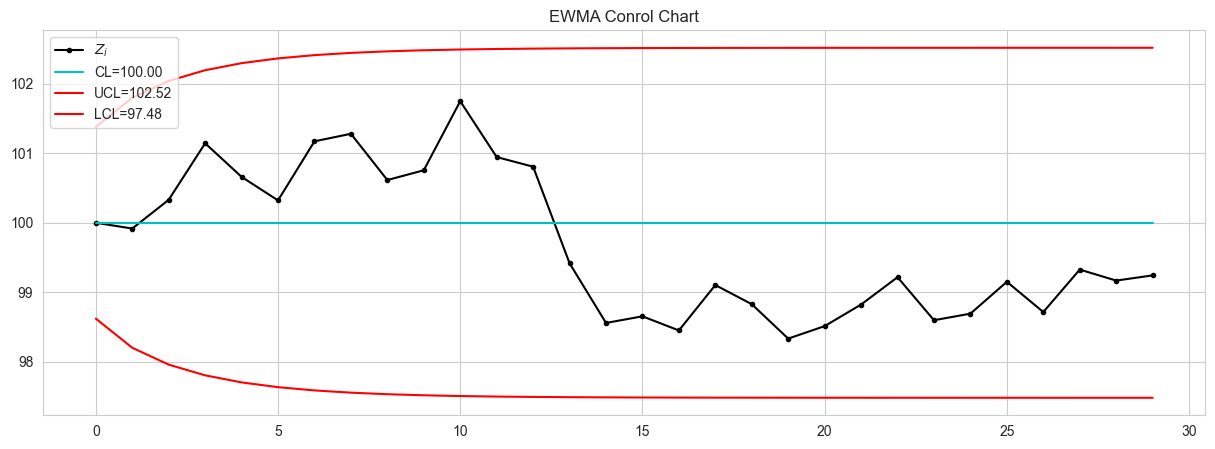

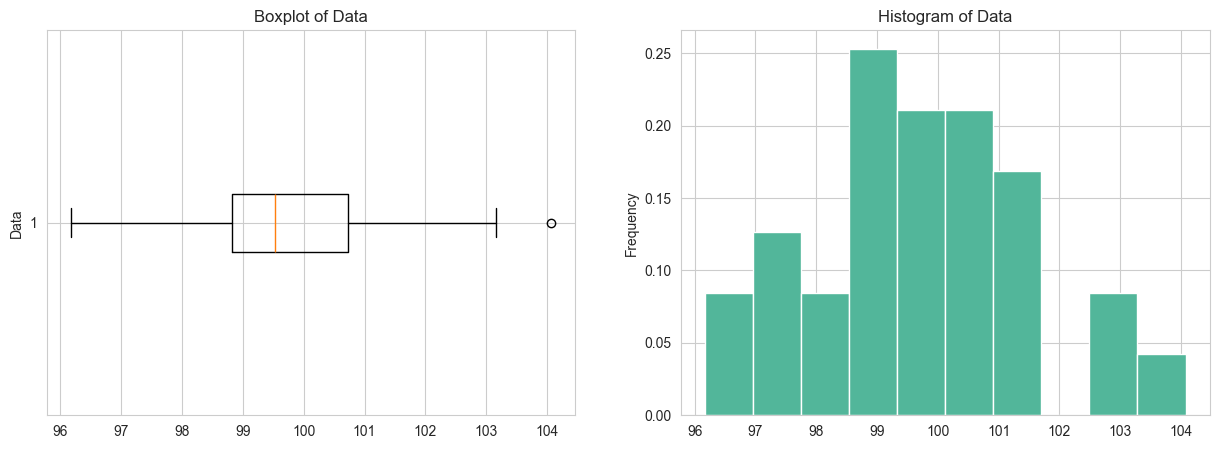

In [57]:
import numpy as np

# 模擬數據
np.random.seed(42)  # 固定隨機種子以保證結果可重現

# 模擬30個樣本，每個樣本的測量值基於正態分布
num_samples = 30  # 總樣本數
mean_value = 100  # 理想平均值
sigma_value = 2   # 標準差（製程變異性）

# 生成測量數據（正態分布，均值=100，標準差=2）
data = np.random.normal(loc=mean_value, scale=sigma_value, size=num_samples)

# 模擬一些異常值（在樣本中引入波動）
data[10] += 5  # 異常升高
data[20] -= 4  # 異常降低

# 顯示生成的數據
print("Generated Semiconductor Data:")
print(data)

# 初始化 EWMA 類並擬合數據
ewma_chart = EWMA()
lamda = 0.3  # 平滑因子（權重），範圍 [0,1]
ewma_chart.fit(data, lamda=lamda, mean=mean_value)

# 繪製 EWMA 控制圖
L = 3  # 控制界限範圍因子（3個標準差）
sigma = sigma_value  # 數據的標準差
ewma_chart.ControlChart(L, sigma)

In [58]:
data4 = np.array(          
    [[[3.29, 3.41, 3.64], 
      [2.44, 2.32, 2.42], 
      [4.34, 4.17, 4.27],
      [3.47, 3.5, 3.64],  
      [2.2, 2.08, 2.16]], 
     [[3.08, 3.25, 3.07], 
      [2.53, 1.78, 2.32],  
      [4.19, 3.94, 4.34],  
      [3.01, 4.03, 3.2],   
      [2.44, 1.8, 1.72]],  
     [[3.04, 2.89, 2.85],   
      [1.62, 1.87, 2.04],  
      [3.88, 4.09, 3.67], 
      [3.14, 3.2, 3.11],    
      [1.54, 1.93, 1.55]]]) 

In [59]:
# 量具重複性與再現性 (Gauge R&R) 分析
# Sources of Variance (變異來源)：
# 1.Operator：測量者的變異 2.Part：被測量的零件（物件）變異 3.Operator by Part：測量者與零件交互的變異
# 4.Measurement：測量本身的誤差 5.Total：總變異 
# 1.DF (自由度)：變異的自由度，與樣本數和變異來源相關 2.SS (平方和)：每個變異來源的平方和，用於量化變異
# 3.MS (均方)：平方和除以自由度 4.Var (變異)：估計的變異量 5.Std (標準差)：變異的平方根
# 6.F-value (F值)：檢驗每個變異來源的重要性 7.P-value (P值)：判斷變異是否顯著，P < 0.05 通常表示該變異來源顯著
# 表格分析：
# 1.Operator 和 Part 的 P-value 都是 0.000，表示這些來源的變異顯著
# Operator by Part 的 P-value 是 0.996，表示這部分交互效應不顯著
# Measurement 部分的變異量很小，標準差 0.239，意味著測量系統本身的誤差較低。
# 這段程式碼的主要目的是檢驗測量系統是否足夠穩定、可重複和可靠。如果 Operator 或 Measurement 部分的變異太高，則測量系統可能需要改進。
# 通過這些圖表可以更直觀地理解哪些來源（零件或操作員）對測量系統的總變異影響最大，並據此優化測量系統

g = GaugeRnR.GaugeRnR(data4)
# 執行 Gauge R&R 分析，計算各變異來源的統計數據
g.calculate()
print(g.summary())

╒═══════════════════════╤══════╤════════╤═══════╤═══════╤═══════╤═══════════╤═══════════╕
│ Sources of Variance   │   DF │     SS │    MS │   Var │   Std │ F-value   │ P-value   │
╞═══════════════════════╪══════╪════════╪═══════╪═══════╪═══════╪═══════════╪═══════════╡
│ Operator              │    2 │  1.63  │ 0.815 │ 0.054 │ 0.232 │ 100.322   │ 0.000     │
├───────────────────────┼──────┼────────┼───────┼───────┼───────┼───────────┼───────────┤
│ Part                  │    4 │ 28.909 │ 7.227 │ 0.802 │ 0.896 │ 889.458   │ 0.000     │
├───────────────────────┼──────┼────────┼───────┼───────┼───────┼───────────┼───────────┤
│ Operator by Part      │    8 │  0.065 │ 0.008 │ 0     │ 0     │ 0.142     │ 0.996     │
├───────────────────────┼──────┼────────┼───────┼───────┼───────┼───────────┼───────────┤
│ Measurment            │   30 │  1.712 │ 0.057 │ 0.057 │ 0.239 │           │           │
├───────────────────────┼──────┼────────┼───────┼───────┼───────┼───────────┼───────────┤
│ Total   

In [60]:
# 生成箱型圖 (Box Plot)，幫助視覺化分析測量系統的變異性來源

# 如果每個零件的測量範圍差異很大，這表明零件本身是主要的變異來源之一
g.creatPartsBoxPlot() # 分析零件之間的變異性

In [61]:
# 如果操作員之間的範圍明顯不同，這表明操作員可能是變異的主要來源之一
g.creatOperatorsBoxPlot() # 分析操作員之間的變異性

In [62]:
X = pd.read_csv("data_X.csv")
submission = pd.read_csv("sample_submission.csv")
Y = pd.read_csv("data_Y.csv")

In [63]:
X.columns, Y.columns, submission.columns

(Index(['date_time', 'T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1',
        'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3',
        'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2',
        'T_data_5_3', 'H_data', 'AH_data'],
       dtype='object'),
 Index(['date_time', 'quality'], dtype='object'),
 Index(['date_time', 'quality'], dtype='object'))

In [64]:
X.shape, Y.shape, submission.shape

((2103841, 18), (29184, 2), (5808, 2))

In [65]:
X.info(), Y.info(), submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103841 entries, 0 to 2103840
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date_time   object 
 1   T_data_1_1  int64  
 2   T_data_1_2  int64  
 3   T_data_1_3  int64  
 4   T_data_2_1  int64  
 5   T_data_2_2  int64  
 6   T_data_2_3  int64  
 7   T_data_3_1  int64  
 8   T_data_3_2  int64  
 9   T_data_3_3  int64  
 10  T_data_4_1  int64  
 11  T_data_4_2  int64  
 12  T_data_4_3  int64  
 13  T_data_5_1  int64  
 14  T_data_5_2  int64  
 15  T_data_5_3  int64  
 16  H_data      float64
 17  AH_data     float64
dtypes: float64(2), int64(15), object(1)
memory usage: 288.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29184 entries, 0 to 29183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  29184 non-null  object
 1   quality    29184 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 456.1+ KB
<class

(None, None, None)

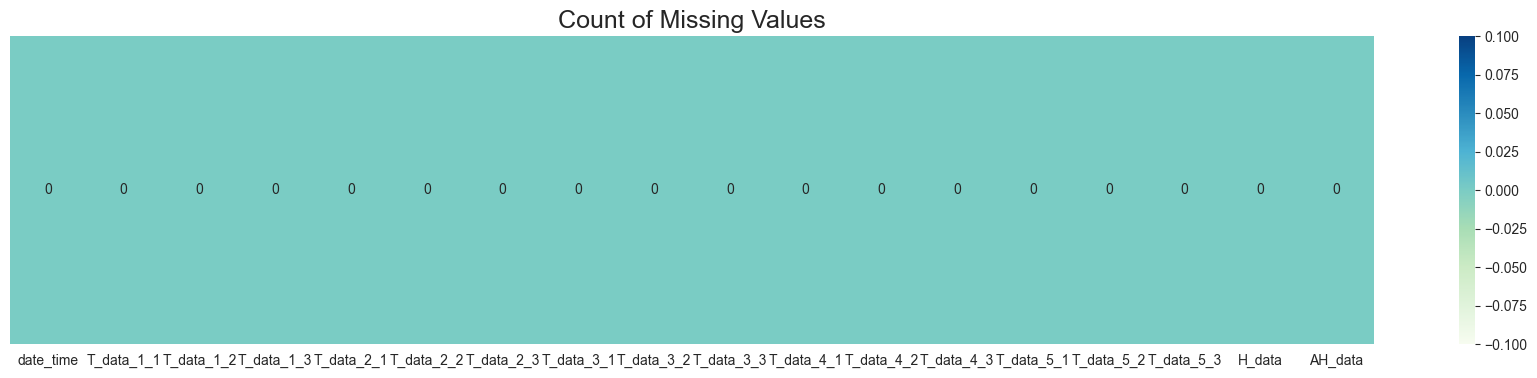

In [66]:
# heatmap 看 missing values 的分布
plt.figure(figsize=(22,4))
sns.heatmap((X.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [67]:
# .describe() -> 數值型(會生成統計摘要) 與 類別型(會生成與頻率相關的摘要信息) 的 欄位 用此方法所得出的結果不同
# 若欄位為數值型：count(非空值的數量).mean(平均值).std(標準差).min.25%.50%.75%(四分位數（分別是第 25%、50%(中位數) 和 75% 的百分位數）).max
# 若欄位為類別型：count(非空值的數量).unique(唯一值的數量).top(出現次數最多的值（眾數）).freq(眾數的出現次數)
# pandas有两个核心数据结构 Series和DataFrame，分别对应了一维的序列和二维的表结构。
# 而describe()函数就是返回这两个核心数据结构的统计变量。其目的在于观察这一系列数据的范围、大小、波动趋势等等，为后面的模型选择打下基础。
# 四分位數 (Quartile)：四分位數將數據分為四等份 # 50% 四分位數 = 中位數 (Median) 而不是 平均值
# 25%（第一四分位數，Q1）：數據中前 25% 的數值 / 50%（第二四分位數，Q2）：數據的中位數，表示數據中有一半的值小於等於它 / 75%（第三四分位數，Q3）：數據中前 75% 的數值


X.describe()[1:].T.style.background_gradient(cmap='GnBu', axis=1)

,mean,std,min,25%,50%,75%,max
T_data_1_1,250.182182,32.116609,-198.000000,229.000000,250.000000,272.000000,724.000000
T_data_1_2,250.091514,30.824510,-122.000000,229.000000,250.000000,272.000000,762.000000
T_data_1_3,250.253580,30.691253,-107.000000,229.000000,250.000000,272.000000,665.000000
T_data_2_1,349.775603,42.259606,-703.000000,328.000000,350.000000,372.000000,1302.000000
T_data_2_2,349.721759,40.678867,-958.000000,328.000000,350.000000,372.000000,1179.000000
T_data_2_3,349.828165,37.984437,-191.000000,328.000000,350.000000,372.000000,889.000000
T_data_3_1,501.161070,63.257324,-775.000000,464.000000,502.000000,538.000000,1587.000000
T_data_3_2,501.109222,63.371641,-759.000000,464.000000,502.000000,538.000000,2505.000000
T_data_3_3,501.233550,62.232944,-613.000000,464.000000,502.000000,539.000000,1319.000000
T_data_4_1,349.319616,39.305621,-514.000000,327.000000,349.000000,372.000000,1177.000000


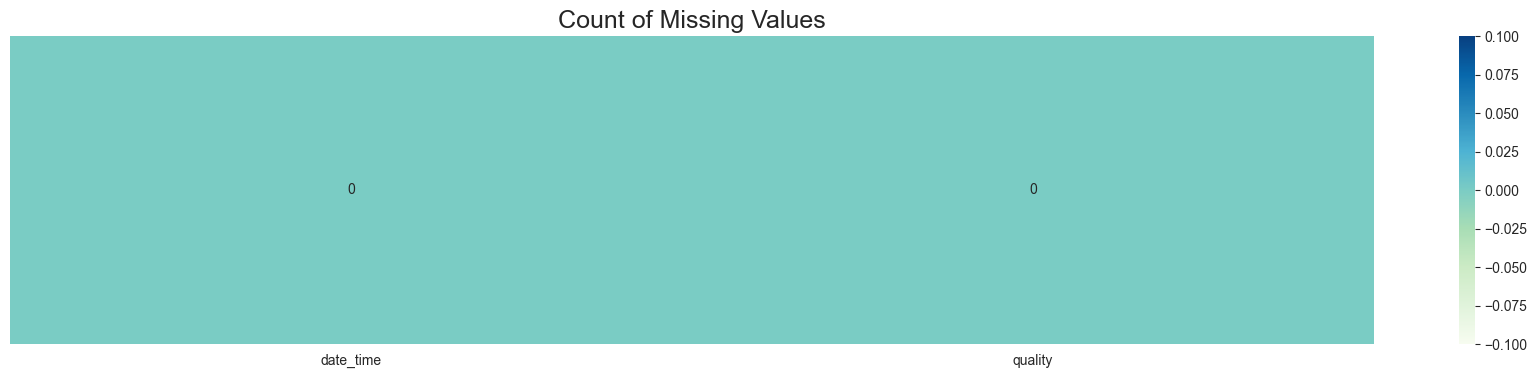

In [68]:
# 查看 missing value 分布
plt.figure(figsize=(22,4))
sns.heatmap((Y.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [69]:
Y.describe()[1:].T.style.background_gradient(cmap='GnBu', axis=1)

,mean,std,min,25%,50%,75%,max
quality,402.800747,46.273228,221.000000,372.000000,408.000000,439.000000,505.000000


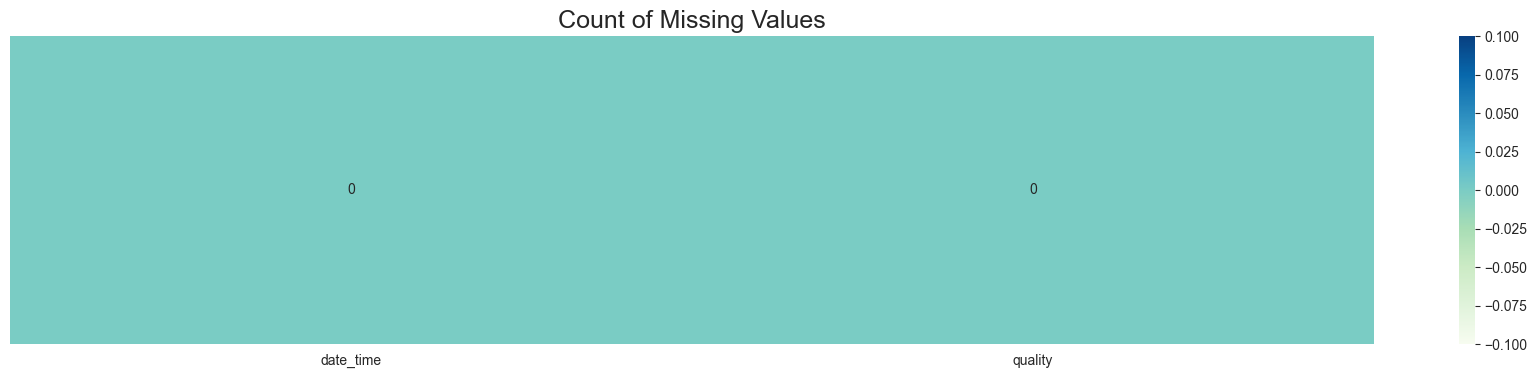

In [70]:
# 查看 missing value 分布
plt.figure(figsize=(22,4))
sns.heatmap((submission.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [71]:
submission.describe()[1:].T.style.background_gradient(cmap='GnBu', axis=1)

,mean,std,min,25%,50%,75%,max
quality,420.000000,0.000000,420.000000,420.000000,420.000000,420.000000,420.000000


In [72]:
# 多一個 date_hour 欄位 存 date_time 的日期、小時
X["date_time"]=pd.to_datetime(X["date_time"])
X["date_hour"] = X["date_time"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
X

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,date_hour
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22,01-01-2015-00
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22,01-01-2015-00
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22,01-01-2015-00
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22,01-01-2015-00
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22,01-01-2015-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103836,2018-12-31 23:56:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,157.20,8.44,31-12-2018-23
2103837,2018-12-31 23:57:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.40,8.44,31-12-2018-23
2103838,2018-12-31 23:58:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.14,8.44,31-12-2018-23
2103839,2018-12-31 23:59:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,162.96,8.44,31-12-2018-23


In [73]:
# 將 date_time 欄位轉換為日期時間格式 (datetime) 對日期時間進行時間偏移，減去 1 小時。 再次轉換日期時間為字串格式，按照特定格式輸出 ("%d-%m-%Y-%H")
Y["date_shifted"] = pd.to_datetime(Y["date_time"]) - datetime.timedelta(hours=1)
Y["date_shifted"] = pd.to_datetime(Y["date_shifted"])
Y["date_shifted"] = Y["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))

In [74]:
training = pd.merge(X,Y[["date_shifted","quality"]],left_on="date_hour",right_on="date_shifted",how="inner")
training

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,...,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,date_hour,date_shifted,quality
0,2015-01-03 23:00:00,265,337,263,335,326,340,493,497,527,...,343,336,234,239,237,157.37,4.73,03-01-2015-23,03-01-2015-23,392
1,2015-01-03 23:01:00,265,337,263,335,326,341,494,497,529,...,343,336,234,238,237,152.83,4.73,03-01-2015-23,03-01-2015-23,392
2,2015-01-03 23:02:00,265,337,263,335,326,341,494,497,530,...,344,336,234,238,238,156.82,4.73,03-01-2015-23,03-01-2015-23,392
3,2015-01-03 23:03:00,266,338,263,335,326,341,495,497,532,...,345,336,234,238,238,154.81,4.73,03-01-2015-23,03-01-2015-23,392
4,2015-01-03 23:04:00,266,338,263,335,326,341,495,497,534,...,346,336,234,238,238,154.92,4.73,03-01-2015-23,03-01-2015-23,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751035,2018-05-03 22:55:00,253,257,256,350,350,356,448,448,439,...,345,341,256,267,246,153.40,8.90,03-05-2018-22,03-05-2018-22,454
1751036,2018-05-03 22:56:00,253,257,256,350,350,356,448,449,439,...,345,340,256,267,246,158.97,8.90,03-05-2018-22,03-05-2018-22,454
1751037,2018-05-03 22:57:00,253,257,256,350,350,356,449,449,439,...,345,339,256,267,246,156.20,8.90,03-05-2018-22,03-05-2018-22,454
1751038,2018-05-03 22:58:00,253,257,256,350,350,356,449,450,439,...,344,338,256,267,246,157.49,8.90,03-05-2018-22,03-05-2018-22,454


In [75]:
# 對 submission 資料進行日期時間格式的處理，新增一個名為 date_hour 的欄位，將日期時間格式化為特定的形式（"%d-%m-%Y-%H"）。
# 將資料集 X 和 submission 進行內連接 (inner join)，基於共同的 date_hour 欄位來匹配數據，並將 submission 中的 quality 欄位合併到 validation 中
submission["date_hour"] = pd.to_datetime(submission["date_time"]).apply(lambda x: x.strftime("%d-%m-%Y-%H"))
validation = pd.merge(X,submission[["date_hour","quality"]],left_on="date_hour",right_on="date_hour",how="inner")

In [76]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=0)
X_val = training.drop(["date_hour", "date_shifted", "quality"], axis=1)
y_val = training["quality"]

In [77]:
X_val['date_time'] = X_val['date_time'].astype('int64')

In [78]:
# 決策樹回歸模型 (dt_model) 進行 交叉驗證，並以 負平均絕對誤差 (Negative Mean Absolute Error, MAE) 作為評估指標來衡量模型表現
# cv=5：將數據分為 5 個子集（5 折交叉驗證）。每次用其中 1 個子集作為測試集，其餘 4 個子集作為訓練集。模型將訓練和測試 5 次，每次測試一個不同的子集
# Scikit-learn 的分數方向為「越大越好」，因此 MAE 被轉為負值。如果 MAE 的值越小，模型預測越精準；因此負值越接近 0，模型越好
# error_score='raise'：如果在交叉驗證過程中出現錯誤，則拋出異常。 默認情況下，如果模型報錯，會返回 NaN。
cv_dt = cross_val_score(dt_model,X_val,y_val,cv=5,scoring=('neg_mean_absolute_error'),error_score='raise')

In [79]:
cv_dt

array([-15.54470486, -15.26699276, -14.79208927, -14.26509389,
       -15.99990291])

In [80]:
print("Average Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.mean())))
print("Best Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.max())))

Average Decision Tree Cross Validation MAE: 15.173756738852338
Best Decision Tree Cross Validation MAE: 14.265093887061404


In [81]:
X_train,X_test,y_train,y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=0)
dt_model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [82]:
predictions_dt = dt_model.predict(X_test)
results = pd.DataFrame()
results["True"] = y_test
results["Predicted DecisionTree"]=predictions_dt
results

,True,Predicted DecisionTree
1135424,448,448.0
1661364,390,390.0
754389,374,374.0
701569,309,309.0
662658,287,287.0
...,...,...
1650459,264,264.0
233824,410,410.0
996853,336,336.0
16630,412,412.0


In [83]:
print("DecisionTree Regressor MAE: {0}".format(mean_absolute_error(y_test,predictions_dt)))

DecisionTree Regressor MAE: 0.38343689083820665


In [84]:
model = DecisionTreeRegressor(random_state=0)
model.fit(X_val,y_val)

DecisionTreeRegressor(random_state=0)

In [85]:
# 刪除 validation 資料集中的欄位
validation = validation.drop(["date_hour","quality"],axis=1)
# submission 中只保留了 date_time 和 quality，其他欄位被刪除
submission = submission[["date_time","quality"]]
submission

,date_time,quality
0,2018-05-04 00:05:00,420
1,2018-05-04 01:05:00,420
2,2018-05-04 02:05:00,420
3,2018-05-04 03:05:00,420
4,2018-05-04 04:05:00,420
...,...,...
5803,2018-12-31 19:05:00,420
5804,2018-12-31 20:05:00,420
5805,2018-12-31 21:05:00,420
5806,2018-12-31 22:05:00,420


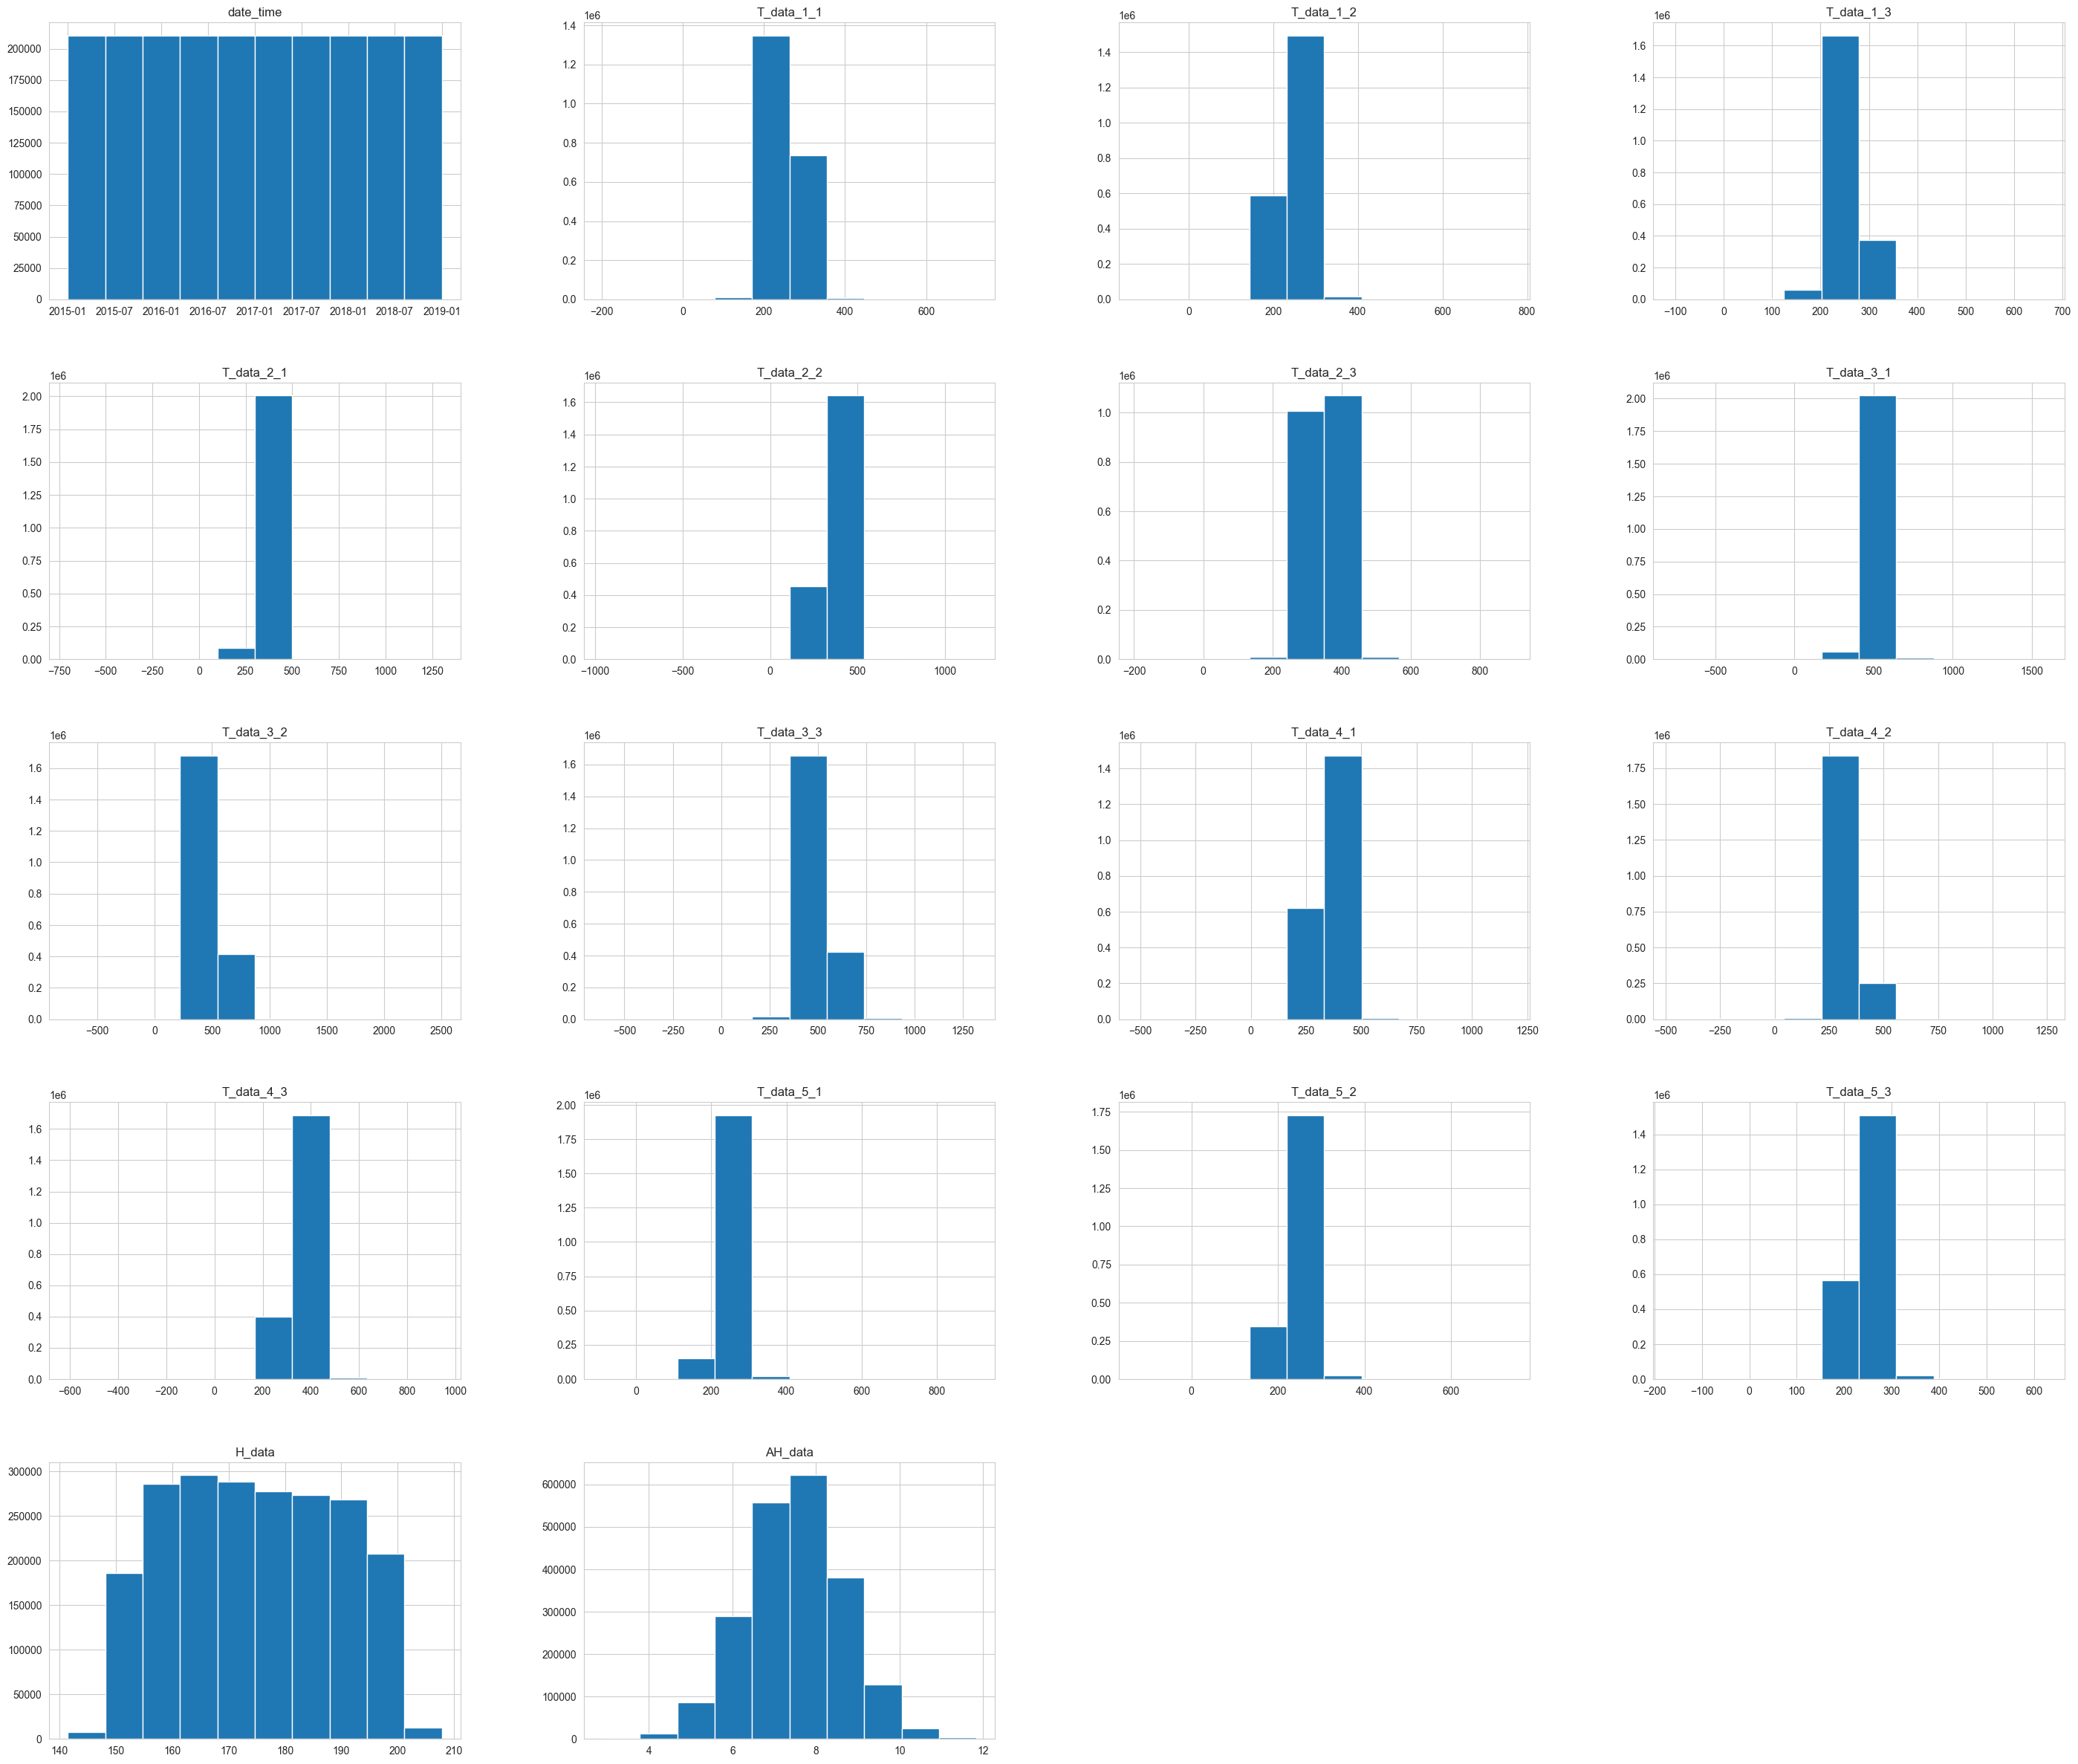

In [86]:
X.hist(figsize=(35, 30));